# Iris Categorisation - TensorFlow

Based on the example [here](https://www.tensorflow.org/guide/premade_estimators)

In [1]:
train_path = 'iris_training.csv'  # http://download.tensorflow.org/data/iris_training.csv
test_path = 'iris_test.csv'       # http://download.tensorflow.org/data/iris_test.csv

In [2]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth',
                    'PetalLength', 'PetalWidth', 'Species']
SPECIES = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

## Explore the data

In [3]:
!head -n5 {train_path}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


The first line of the csv gives a count of the number of training examples (120), the number of features for each (4) and then a species list.  We set the features names ourselves.

In [4]:
def iris_csv_to_df(csv_path):
    df = pd.read_csv(csv_path, names=CSV_COLUMN_NAMES, header=0)
    df['Species'] = df['Species'].map(SPECIES)
    return df

In [5]:
train_df, test_df = map(iris_csv_to_df, (train_path, test_path))

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [7]:
train_df.head()

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,6.4,2.8,5.6,2.2,Virginica
1,5.0,2.3,3.3,1.0,Versicolor
2,4.9,2.5,4.5,1.7,Virginica
3,4.9,3.1,1.5,0.1,Setosa
4,5.7,3.8,1.7,0.3,Setosa


In [8]:
from jupyterthemes import jtplot

# currently installed theme will be used to
# set plot style if no arguments provided
jtplot.style()

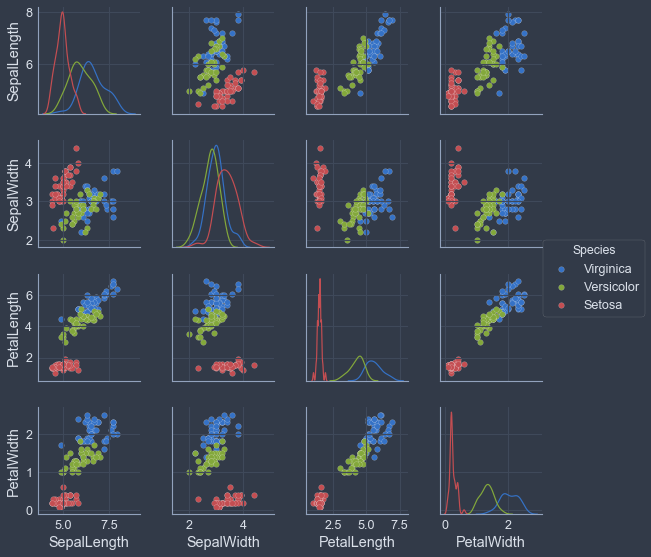

In [9]:
sns.pairplot(train_df, hue='Species', diag_kind='kde', size=2);

The *Setosa* species can be clearly identified based on its petals.  Differentiating between the other reliably may take a combination of features. 

*Sepal Length* obviously wont do it on its own

## Learn a Model

In [11]:
import tensorflow as tf
import tensorflow.estimator.inputs as tfi

In [12]:
# return to raw data
train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)

train_x, train_y = train, train.pop('Species')
test_x, test_y = test, test.pop('Species')

In [13]:
BATCH_SIZE = 100
TRAIN_STEPS = 1000

In [14]:
# Feature columns describe how to use the input.
my_feature_columns = [
    tf.feature_column.numeric_column(key)
    for key in train_x.keys()
]

In [15]:
# Build 2 hidden layer DNN with 10, 10 units respectively.

# ! Must create a new classifier instance every time we train
# or successive training events will build on previous ones.
# Alternatively, set the model output dir manually and remove

classifier = tf.estimator.DNNClassifier(
    feature_columns=my_feature_columns,
    hidden_units=[10, 10], 
    n_classes=3,  # 3 species of iris to group by
);

# Train the Model.
classifier.train(
    input_fn=tfi.pandas_input_fn(
        train_x, train_y, BATCH_SIZE, 
        shuffle=True, num_epochs=1000
    ),
    steps=TRAIN_STEPS,
);

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/1x/gyr4jt_s3jqc2c88vy74btnm0000gn/T/tmp703j0zoq', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x106b15ef0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 i

In [16]:
# Evaluate the model.
eval_result = classifier.evaluate(
    input_fn=tfi.pandas_input_fn(test_x, test_y, BATCH_SIZE, shuffle=False)
);

print('\nTest set accuracy: {accuracy:0.3f}'.format(**eval_result))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-09-15-06:29:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/1x/gyr4jt_s3jqc2c88vy74btnm0000gn/T/tmp703j0zoq/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-09-15-06:29:13
INFO:tensorflow:Saving dict for global step 1000: accuracy = 0.96666664, average_loss = 0.058480117, global_step = 1000, loss = 1.7544035
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1000: /var/folders/1x/gyr4jt_s3jqc2c88vy74btnm0000gn/T/tmp703j0zoq/model.ckpt-1000

Test set accuracy: 0.967


## Generate Predictions
Use unseen data to test the model

TODO! Plot these test values in some scatter plots to see how easy the original author made this

In [17]:
# Define unseen examples to validate model against
valid = pd.DataFrame({
    'SepalLength': [5.1, 5.9, 6.9],
    'SepalWidth': [3.3, 3.0, 3.1],
    'PetalLength': [1.7, 4.2, 5.4],
    'PetalWidth': [0.5, 1.5, 2.1],
    'Species': ['Setosa', 'Versicolor', 'Virginica'],
})
valid_x = valid.drop('Species', axis=1)

In [20]:

# Use model to generate predictions
predictions = classifier.predict(
    input_fn=tfi.pandas_input_fn(valid_x, shuffle=False)
)
    
template = ('\nPrediction is "{}" ({:.1f}%), expected "{}"')

for pred_dict, expec in zip(predictions, valid['Species']):
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print(template.format(SPECIES[class_id], 100 * probability, expec))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/1x/gyr4jt_s3jqc2c88vy74btnm0000gn/T/tmp703j0zoq/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Prediction is "Setosa" (99.8%), expected "Setosa"

Prediction is "Versicolor" (99.9%), expected "Versicolor"

Prediction is "Virginica" (93.2%), expected "Virginica"


#### Examine the examples

These examples were provided by the documentation.  Lets take a look at how easy they made it for themselves.

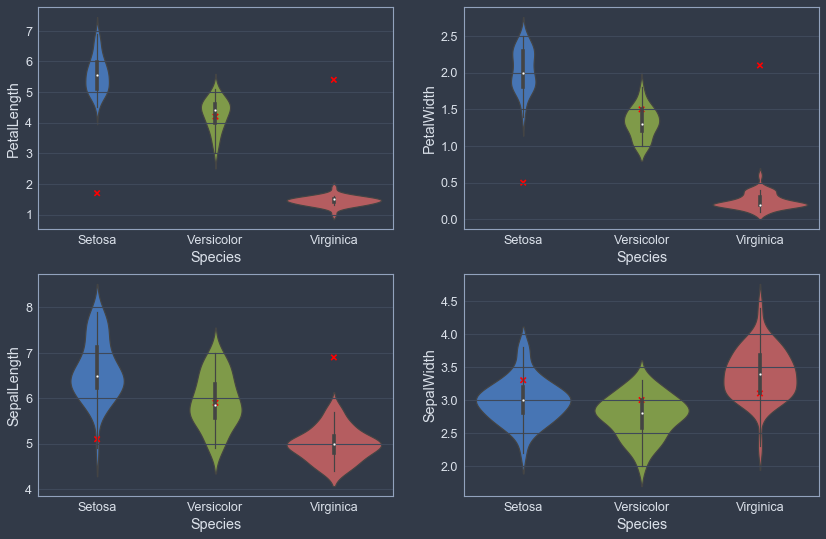

In [21]:
def compare_plot(column):
    ax = sns.violinplot('Species', column, data=train_df)
    sns.pointplot(x='Species', y=column, data=valid, ax=ax, color='red', markers='x', join=False)

plt.figure(figsize=(14,9))
for i, feature in enumerate(valid_x.columns):
    plt.subplot(2,2,i+1)
    compare_plot(feature)

We may have expected a contrived example to use easy validation points but we see above that - with the exception of the *Versicolor* example - the examples are not typical of their species based on Sepal and Petal mesurments.